# Adversarial Validation: Private vs. Public Leaderboard

According to [this](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/342403) discussion, the test dataset for the public leaderboard only contains entries with `product_code` column equal to `F`. All remaining entries are used for the test dataset of the private leaderboard. The goal of this notebook is to investigate whether the distributions of features differs between both datasets. 

I have found a bunch of notebooks in the discussion forum of this competition dealing with adversarial validation in the context of separating training and testing datasets. For this reason, I will not go into much detail about the basic concepts behind this topic within the scope of this notebook. For those readers who are new to this topic, however, I recommend the [notebook](https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation/notebook) created by Carl McBride Ellis as a starting point.

In [31]:
import gc

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (13, 10)})

SEED = 42

Lets load the test file and apply some very basic preprocessing to it.

In [17]:
# load csv and set id column as index

df = pd.read_csv('../data/test.csv').set_index('id')
# lable encode categorical columns
cat_cols = ['attribute_0', 'attribute_1']

for col in cat_cols:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes


In [18]:
# fill missing values with product median
    
for col in df.filter(regex='measurement_').columns.tolist():
    df[col] = df.groupby('product_code')[col].transform(lambda x: x.fillna(x.median()))
    
df['loading'] = df.groupby('product_code')['loading'].transform(lambda x: x.fillna(x.median()))

# apply StandardScaler to continuous columns
scaler = StandardScaler()

cols = df.columns.drop(cat_cols + ['product_code', 'attribute_2', 'attribute_3']).tolist()
df[cols] = scaler.fit_transform(df[cols])

We will also create a new column indicating the origin of each observation in our dataset (i.e. public or private). Dont forget to drop the `product_code` column!

In [19]:
df['origin'] = 'private'
df.loc[df.product_code == 'F', 'origin'] = 'public'
df = df.drop('product_code', axis=1)

We are now ready to perform adversarial validation. We will use `LogisticRegression` classifier and `roc_auc` score as our metric.

In [20]:
features = df.columns.drop('origin').tolist()
target = 'origin'

clf = LogisticRegression(random_state=SEED)
cv_results = cross_validate(clf, df[features], df[target], scoring='roc_auc', cv=5)

print(cv_results['test_score'].mean())

1.0


It looks like our model can perfectly distinguish between the two datasets. Lets have a closer look at the coefficients.

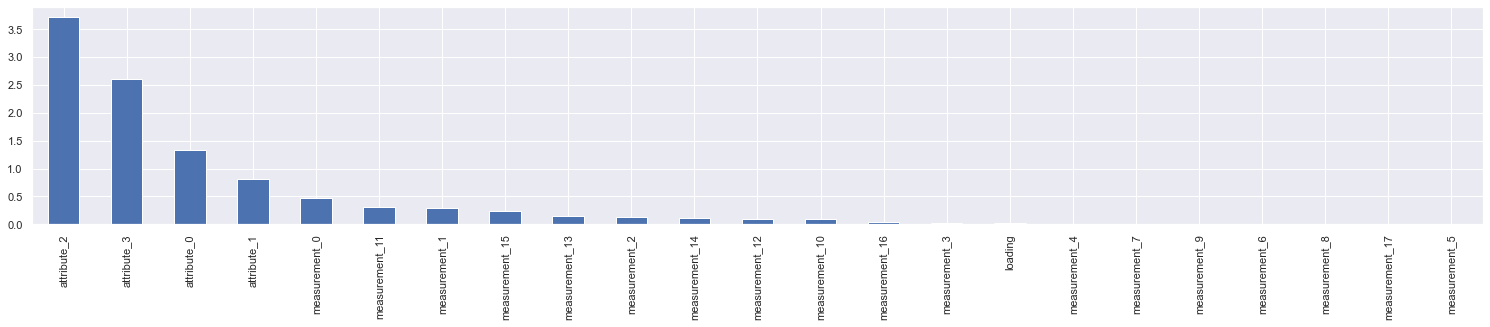

In [21]:
clf.fit(df[features], df[target])
ax = pd.Series(clf.coef_.flatten(), index=features).abs().sort_values(ascending=False).plot(kind='bar', figsize=(26, 4))

The attribute columns seem to have the most impact on the model's decision. Let's take a closer look at these attributes. This time we load both datasets (training and testing) and label them accordingly.

In [22]:
# load data from disc and set id column as index

train = pd.read_csv('../data/train.csv').set_index('id')
test = pd.read_csv('../data/test.csv').set_index('id')

# create the origin column and set its values

train['origin'] = 'train'
test['origin'] = 'private'

# we know that the public leaderboard is evaluated only on products with code F

test.loc[test.product_code == 'F', 'origin'] = 'public'

# for the test dataset, we set the target variable equal to -1 to avoid nan values after merging

test['failure'] = -1

# concatenate both datasets and clear memory

df = pd.concat([train, test], axis=0)

del train, test
_ = gc.collect()


We start with the attribute 0 column.

### Attribute 0

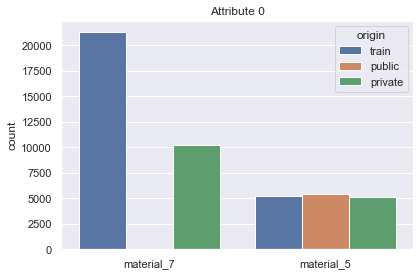

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(data=df, x='attribute_0', hue='origin', ax=ax)
ax.set_title('Attribute 0')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

Only `material_5` is present in all three datasets. Lets calculate the probability of product failure if `material_5` was used and compare it with the probability of product failure if another material was used instead.

In [24]:
# Event A: product failure
# Event B: material 5 was used

# Probability of A & B:

p_ab = df[(df.origin == 'train') & (df.failure == 1) & (df.attribute_0 == 'material_5')]['attribute_0'].value_counts().iloc[0]

# Probability of B:

p_b = df[(df.origin == 'train') & (df.attribute_0 == 'material_5')]['attribute_0'].value_counts().iloc[0]

# Conditional probability of event A given that B occured:

print('The probability of a product failure if material 5 was used is: {:.1f}%'.format(p_ab / p_b * 100))

The probability of a product failure if material 5 was used is: 20.0%


In [25]:
# Event A: product failure
# Event B: material 5 was NOT used

# Probability of A & B:

p_ab = df[(df.origin == 'train') & (df.failure == 1) & (df.attribute_0 != 'material_5')]['attribute_0'].value_counts().iloc[0]

# Probability of B:

p_b = df[(df.origin == 'train') & (df.attribute_0 != 'material_5')]['attribute_0'].value_counts().iloc[0]

# Conditional probability of event A given that B occured:

print('The probability of a product failure if material 5 was NOT used is: {:.1f}%'.format(p_ab / p_b * 100))

The probability of a product failure if material 5 was NOT used is: 21.6%


**Insights**: Consider a new feature which indicates whether `material_5` was used.

We will now have a closer look at attribute 1.

### Attribute 1

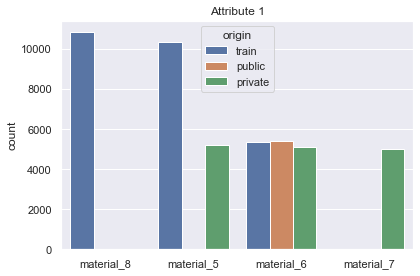

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(data=df, x='attribute_1', hue='origin', ax=ax)
ax.set_title('Attribute 1')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

Only `material_6` is present in all three data sets. We calculate the same probabilities as for `material_5`.

In [27]:
# Event A: product failure
# Event B: material 6 was used

# Probability of A & B:

p_ab = df[(df.origin == 'train') & (df.failure == 1) & (df.attribute_1 == 'material_6')]['attribute_1'].value_counts().iloc[0]

# Probability of B:

p_b = df[(df.origin == 'train') & (df.attribute_1 == 'material_6')]['attribute_1'].value_counts().iloc[0]

# Conditional probability of event A given that B occured:

print('The probability of a product failure if material 6 was used is: {:.1f}%'.format(p_ab / p_b * 100))

The probability of a product failure if material 6 was used is: 20.7%


In [28]:
# Event A: product failure
# Event B: material 6 was NOT used

# Probability of A & B:

p_ab = df[(df.origin == 'train') & (df.failure == 1) & (df.attribute_1 != 'material_6')]['attribute_1'].value_counts().sum()

# Probability of B:

p_b = df[(df.origin == 'train') & (df.attribute_1 != 'material_6')]['attribute_1'].value_counts().sum()

# Conditional probability of event A given that B occured:

print('The probability of a product failure if material 6 was NOT used is: {:.1f}%'.format(p_ab / p_b * 100))

The probability of a product failure if material 6 was NOT used is: 21.4%


**Insights**: Consider another new feature which indicates whether `material_6` was used.

Within the scope of this notebook, we won't examine attributes 2 and 3 in more detail and will instead focus on the measurement columns.

### Measurement Columns

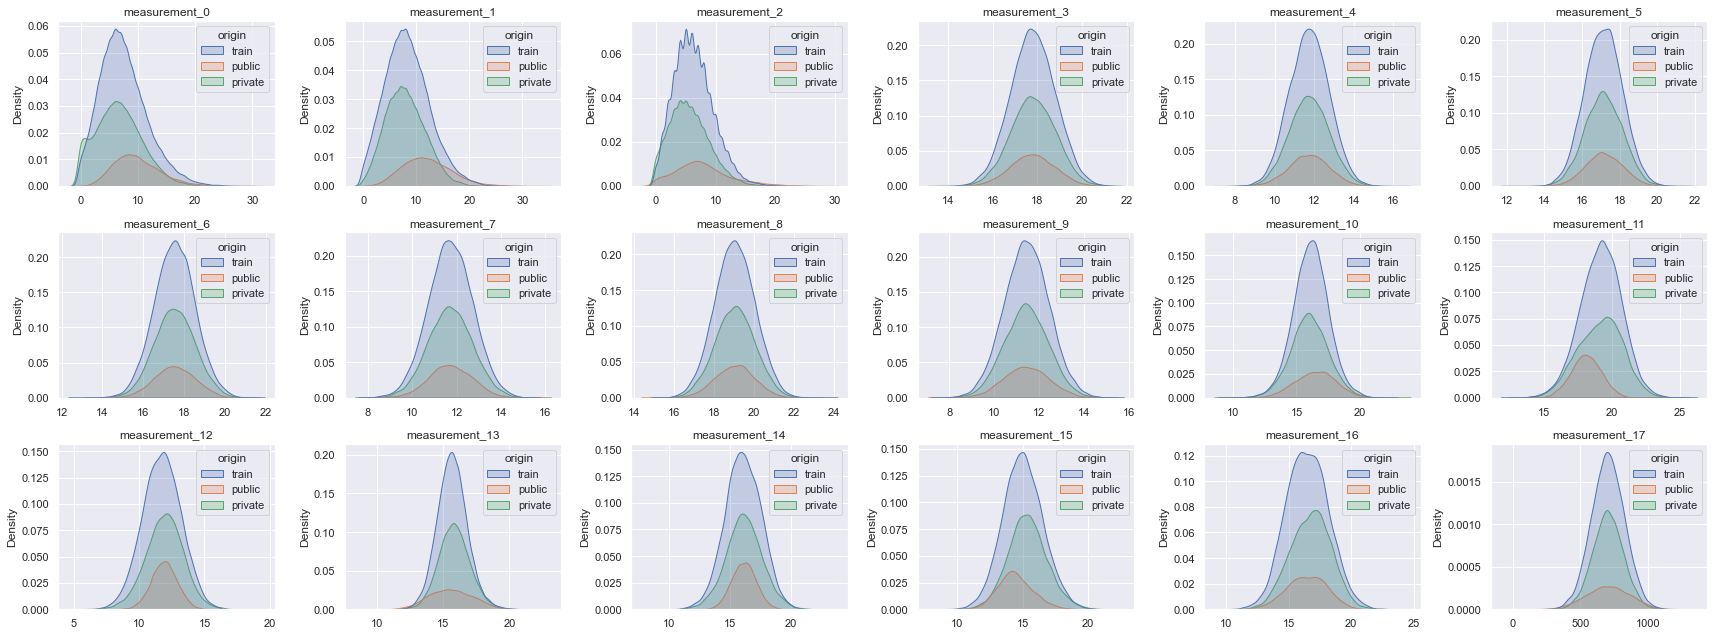

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24, 9))
ax = ax.flatten()

for i, col in enumerate(df.filter(regex='measurement_').columns.tolist()):
    sns.kdeplot(data=df, x=col, hue='origin', fill=True, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

Even a first look at the graphs reveals that there are features whose distributions differ significantly between the training, private and public datasets. We verify our observation with the Kolmogorov-Smirnov test.

In [32]:
# H0: train and public are from the same distribution
# H1: train and public are from different distributions
# We choose a confidence level of 95%, that is, we will reject H0 in favor of H1 if the p-value is less than 0.05

ks_test = pd.DataFrame()
for col in df.filter(regex='measurement_').columns.tolist():
    statistic, pvalue = sp.stats.kstest(df[df.origin == 'train'][col], df[df.origin == 'public'][col])
    ks_test = ks_test.append(pd.DataFrame(data=pvalue, columns=['p_value'], index=[col]))

print(ks_test.round(2))

                p_value
measurement_0      0.00
measurement_1      0.00
measurement_2      0.00
measurement_3      0.38
measurement_4      0.42
measurement_5      0.08
measurement_6      0.65
measurement_7      0.67
measurement_8      0.45
measurement_9      0.24
measurement_10     0.00
measurement_11     0.00
measurement_12     0.00
measurement_13     0.00
measurement_14     0.00
measurement_15     0.00
measurement_16     0.04
measurement_17     0.00


In [15]:
# H0: train and private are from the same distribution
# H1: train and private are from different distributions
# We choose a confidence level of 95%, that is, we will reject H0 in favor of H1 if the p-value is less than 0.05

ks_test = pd.DataFrame()
for col in df.filter(regex='measurement_').columns.tolist():
    statistic, pvalue = sp.stats.kstest(df[df.origin == 'train'][col], df[df.origin == 'private'][col])
    ks_test = ks_test.append(pd.DataFrame(data=pvalue, columns=['p_value'], index=[col]))

print(ks_test.round(2))

                p_value
measurement_0      0.00
measurement_1      0.00
measurement_2      0.00
measurement_3      0.35
measurement_4      0.85
measurement_5      0.61
measurement_6      0.83
measurement_7      0.69
measurement_8      0.36
measurement_9      0.12
measurement_10     0.00
measurement_11     0.00
measurement_12     0.00
measurement_13     0.00
measurement_14     0.00
measurement_15     0.00
measurement_16     0.00
measurement_17     0.00


**Insights**: Consider removing columns `measurement_0`, `measurement_1`, `measurement_2`, `measurement_10`, `measurement_11`, `measurement_12`, `measurement_13`, `measurement_14`, `measurement_15`, `measurement_16` and `measurement_17`.